
Estimate best MSM for a given system
----------
This notebook demonstrates how to compute metastable states and visualize their structures, how to compute the equilibrium probabilities of and transition rates between metastable states, and how to compute transition pathways. It covers everything I (Ryan M.) learned at the 2016 PyEmma workshop in Berlin.

The notebook uses TICA and Bayesian HMM estimation to determine the metastable states of your system and calculates the maximum likelihood MSM among those metastable states. The intuitive (and, in fact, mathematical) understanding of what's going on is that there is a distribution of possible Markov State Models to describe both the microstates (TICA, k-means and maximum likelihood MSM estimation[1]) and macrostates (Bayesian HMM estimation[2,3]). We'll find the best of both using (approximations of) Bayes' rule.

To save any plots, do 
savefig(filename.png) after the line of code where the desired figure is generated.

More frames is better. I had trouble running on systems with 1000 frames or fewer. Looks like it needs more data than that.

In [1]:
# Dependencies
import pyemma
import matplotlib.pylab as plt
import numpy as np
import pyemma.coordinates as coor
%pylab inline
import math
import pyemma.msm as msm
import pyemma.plots as mplt
import shortcuts

### Fill in what you're working on
trajfile = "/Users/melvrl13/Documents/groupStuff/ClusteringTrials/Trajectories/SmallF10Mg/F10_150mMMgCl2_strip_stride100.dcd"
topfile = "/Users/melvrl13/Documents/groupStuff/ClusteringTrials/Trajectories/SmallF10Mg/F10.pdb" #must be pdb

# Now let's read in the topology
feat = coor.featurizer(topfile)
# And pick what features to use
# Below uses just use all heavy atom xyz-coordinates
#feat.add_all() #Play with this -- look at pyemma docs
feat.add_selection(feat.select_Heavy())
#feat.add_distances(feat.select("resname U"),indices2=feat.select("resname ZN2"))
#feat.add_distances_ca
#http://www.emma-project.org/v1.2.2/api/generated/pyemma.coordinates.featurizer.html

# I'm not doing things in memory, so arbitrarily large trajectories should be fine.
# Can be sped up by loading into memory -- ref pyemma docs
# Let's make sure everything was read in as expected
inp = coor.source(trajfile, feat) #not read into memory
print('trajectory length = ',inp.trajectory_length(0)) 
print('number of dimension = ',inp.dimension()) 

Populating the interactive namespace from numpy and matplotlib
trajectory length =  1000
number of dimension =  591


`%matplotlib` prevents importing * from pylab and numpy


Make sure the numbers above are what you expected. Dimensions should be 3 X atoms. To change what atoms are used,you'll need to alter your features. The pyemma docs describe how to do this. 

time-lagged independent component analysis (TICA)
----------
In principle we could now directly go on to do data clustering. Because in such a high-dimensional space it is difficult to efficiently discretize data where it matters. So we would like to first reduce our dimension by throwing out the 'uninteresting' ones and only keeping the 'relevant' ones. But how do we do that?

It turns out that a really good way to do that if you are interesting in the slow kinetics of the molecule - e.g. for constructing a Markov model, is to use the time-lagged independent component analysis (TICA) [2]. 

Intuition: Think of TICA as checking PCAs over time and asking how long it takes until dot(PCA1,PCA2)!=0. PCAs are uncorrelated in an instantaneous sense. We're looking for timescales over which they lose this decorrelation. For PCA, if I look at person 1, at that instant, I don't know anything about what person 2 is doing.
For TICA, if I look at person 1, I know what person 2 will be doing later. We want to know how much later. From a theory standpoint, TICA is doing PCA and then looking at how PCAs are correlated in time.

TICA eigenvalues represent lag times. From TICA we can pick the optimal subspace for MSM construction.

We'll make sqrt(number of frames) crisp k-means clusters. It can be shown that since we'll use HMM to coarse grain, the quality of our intiial crisp clustering isn't that important. HMM estimation can unscramble even every bad initial clusterings. The pathological exceptions are extreme.

Think of TICA like the pre-processing step for MSM. Start TICA at a time lag of 1. If you notice what the "right" time lag is for your MSM, go back and redo TICA with that. TICA will get rid of extraneous data this way (i.e., remove features that don't change on that timescale).

Tica-projected data shape =  (1000, 377)
15-03-16 12:22:47 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     The number of cluster centers was not specified, using min(sqrt(N), 5000)=31 as n_clusters.


/Users/melvrl13/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


15-03-16 12:22:47 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     Cluster centers converged after 8 steps.
15-03-16 12:22:49 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[3] WARNING  Some timescales could not be computed. Timescales array is smaller than expected or contains NaNs


/Users/melvrl13/anaconda/envs/python3/lib/python3.4/site-packages/pyEMMA-2.0.4-py3.4-macosx-10.5-x86_64.egg/pyemma/util/statistics.py:59: UserWarning: confidence interval for constant data is not meaningful
  warnings.warn('confidence interval for constant data is not meaningful')


/Users/melvrl13/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


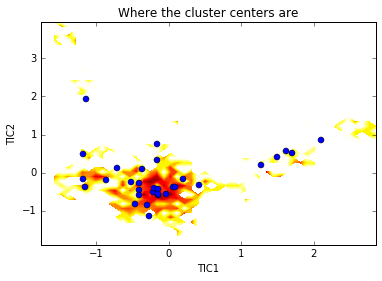

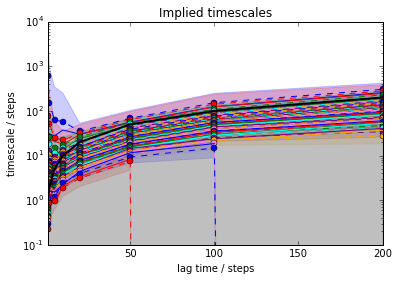

In [2]:
# You can/should redo this with the lag time you decide for the MSM.
# In principle, you should iterate until TICA lag and MSM lag are the same.
# But again, HMMs are quite good at dealing with poor parameters.
lag = 1 #Your choice goes here.

# By not specifying the number of tica coordinates to keep, 
# this will keep the number needed to capture 95% kinetic variance
tica_obj = coor.tica(inp, lag=lag)
Y = tica_obj.get_output()[0] #If you're using more than 1 trajectory as input, remove [0] and adjust code
print('Tica-projected data shape = ',Y.shape)

# Histogram first two dimensions -- just for visuals
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]

# Kmeans clustering
# By default, this will use min(5000,sqrt(frames))
cl = coor.cluster_kmeans(data=Y, max_iter=100) #Increase max_iter if convergence fails
# For later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

# Visualize the clusters on the free energy surface of TIC1-2
figure()
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent) #pylab function
plot(cc_x,cc_y, linewidth=0, marker='o')
title('Where the cluster centers are')
xlabel('TIC1')
ylabel('TIC2')

# Compute implied timescales for a variety of lag times
lags = [1,2,5,10,20,50,100,200] #play with these
its = msm.its(dtrajs, lags=lags, errors='bayes', nsamples=200) #n_jobs is # of processors to use; -1 is all
figure()
mplt.plot_implied_timescales(its)
title('Implied timescales')
# This plot's x-axis is in units of the original trajectory saving step.

In [6]:
cl.index_clusters.shape[0]

31

Timescale decision
----------

Using the above plot, you want to pick the plce where the slow processes (those above the gray area) are mostly converged (generally flat). When looking at implied timescales, you're looking for a plateau, but you can show [4] you'll never actually plateau, so go for "good enough." Don't be picky.

However, your choice *must* be smaller than your shortest trajectory's run time. For example, if I have 1x1microsecond and 3x5microsecond simulations concatenated, I cannot choose a lag time longer than or equal to 1microsecond.

The lag times/steps has units of original trajectory saving time (i.e., a frame in your input trajectory)

MSM
----------
So finally we can estimate a Markov model. In fact we have already estimated a several Markov models (for different lag times above), but now we construct an msm object which will give us access to a wide variety of interesting quantities. All we need to put in are the discrete trajectories obtained from the clustering and the lag time:

fraction of connected states =  1.0
fraction of counts used =  1.0


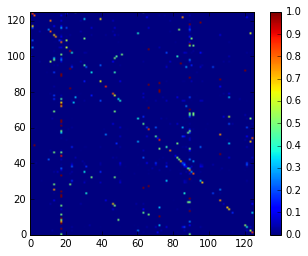

In [4]:
# Pick the best lag time for the MSM.
lagtime = 20 #Your choice goes here
M = msm.estimate_markov_model(dtrajs, lagtime)
print('fraction of connected states = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)
# plot the transition matrix
figure()
imshow(M.transition_matrix,
       extent=(M.active_set.min(), M.active_set.max(), M.active_set.min(), M.active_set.max()))
colorbar()

Sanity check
----------
It is possible that given your lag time selection, you might exclude some states, since the Markov model will be constructed on the largest set of states. So let's check.

If the fraction of states and counts used are (either) less than 1, you have chosen poorly. Play with the TICA lag and Markov lag. If you can't get this to work out, then you're just out of luck. These aren't the droids you're looking for. Move along. 

However, when I've run into problems here, it just took a bit of back and forth between the two lag times. Also, the notebooks still have a bit of Open source/ beta-ness about them. I've found that if things aren't going right simply restarting the notebook kernel and doing everything again solves most things. Kernel> Restart & Clear Output

If you used all your states and counts, then you can go to the next step. 

Spectral analysis
-----------

Let us have a closer look at the timescales that were already seen in the its plot:

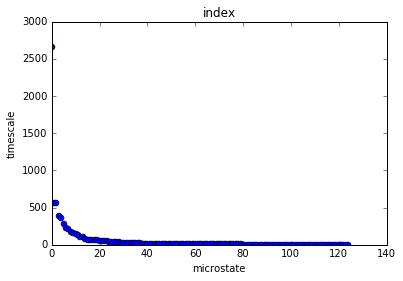

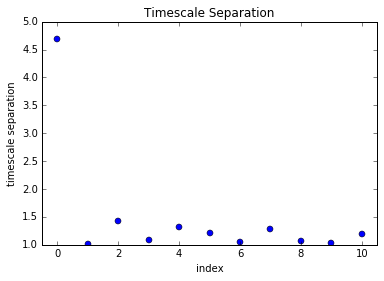

In [5]:
figure()
plot(M.timescales(),linewidth=0,marker='o')
xlabel('microstate'); ylabel('timescale');
title('index')

figure()
plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,10.5)
title('Timescale Separation')

You're looking for the *first* big 'jump' in timescale separations. The points in the second plot are ratios of timescale_(i)/timescale_(i-1). So if your second dot is big, that means that processes 2 and 3 are well separated in time (these are abstract ideas at this point in constructing the model), so you'd say there are 2 "slow" processes. All processes after 2 are "fast"

HMM
----------
The "right" way to coarse grain a MSM is to use a Bayesian hidden HMM calculation[2].

There exists a matrix that maps the observed states in the data to the hidden states in this model. Furthermore, there exists a distribution of possible Markov models for the metastable states in our system. We'll calculate what the best of all possible MSMs is. This is Bayesian MSM estimation.

Basically, you make an initial guess of your hidden trajectory and mapping matrix then iteratively improve with an expectation maximizer. There is a (practically) infinite number of possible hidden trajectories (basically exp(number of frames)).

The methods in PyEMMA for estimating hidden Markov models do NOT assume that the discretized state space is Markovian. It assumes only that the underlying MD is Markovian[6]. Think about that for a minute. It's really cool.

A Bayesian HMM can handle bad initial discretization because it figures out given that you're in hidden state A_i, what's the probability you're in initial discretization state Z_j, so the HMM can unscramble a poor discretization and split up the initial clusters probabilistically.

/Users/melvrl13/anaconda/envs/python3/lib/python3.4/site-packages/msmtools/analysis/dense/pcca.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))


(<matplotlib.figure.Figure at 0x14956f9e8>, array([[ 1.        ,  0.74518189],
        [ 0.        ,  0.        ]]))

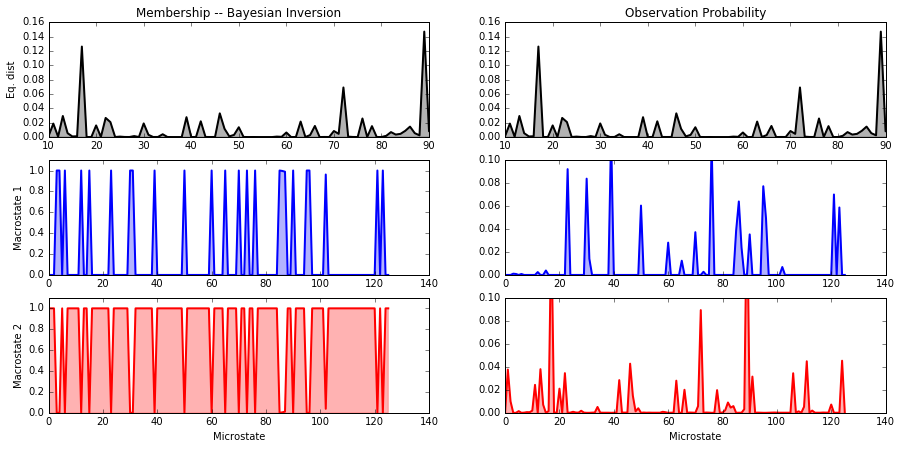

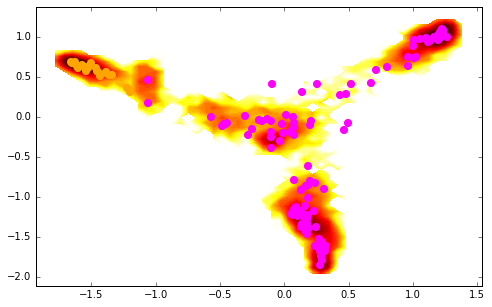

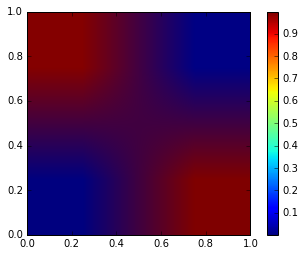

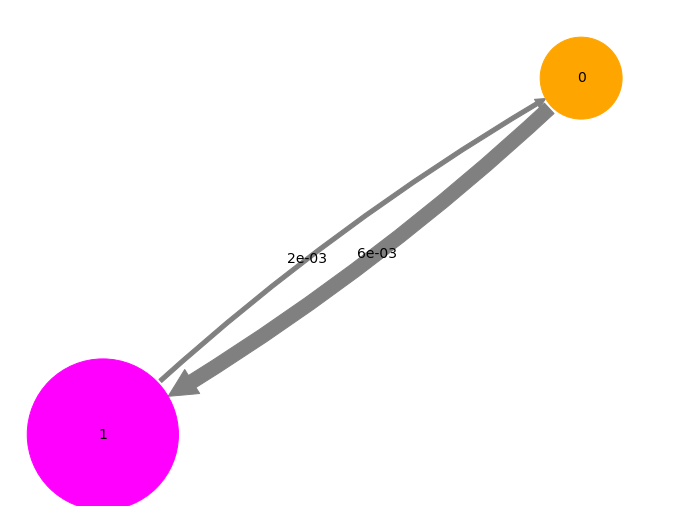

In [6]:
count_slow_processes = 2
HMM = M.coarse_grain(count_slow_processes)

# Now, let's explore the model we've created.

# pretty-plotting function to make things look nice
def plot_pretty(x, y=None, color=None, axes=None, xlim=None, ylim=None, xlabel=None, ylabel=None, title=None):
    if y is None:
        y = x
        x = np.arange(len(y))
    if axes is None:
        axes = gca()
    if color is None:
        color = 'black'
    axes.plot(x, y, color=color, linewidth=2); 
    axes.fill_between(x, np.zeros(len(x)), y, color=color, alpha=0.3); 
    if ylim is not None:
        axes.set_ylim(ylim)
    if xlim is not None:
        axes.set_xlim(xlim)
    if xlabel is not None:
        axes.set_xlabel(xlabel)
    if ylabel is not None:
        axes.set_ylabel(ylabel)
    if title is not None:
        axes.set_title(title)
        
# Since the only "gaurantee" is that you'll have at least 2 macrostates,
# I'll only plot those, but you can edit the code if you like

states = HMM.observable_set #What are the states
statdist = HMM.stationary_distribution_obs #Equilibrium
mems = HMM.metastable_memberships #Original cluster distribution
dists = HMM.metastable_distributions #
sets = HMM.metastable_sets
fig, axes = subplots(3, 2, figsize=(15, 7))

# plot equilibrium distribution and HMM memberships
plot_pretty(states, statdist, axes=axes[0, 0], xlim=(10, 90), ylabel='Eq. dist',
                       title='Membership -- Bayesian Inversion')
plot_pretty(states, mems[:, 0], color='blue', axes=axes[1, 0], ylim=(0, 1.1), ylabel='Macrostate 1',)
plot_pretty(states, mems[:, 1], color='red', axes=axes[2, 0], ylim=(0, 1.1), ylabel='Macrostate 2',
           xlabel='Microstate')
#If I'm in microstate x, what's the probability I'm in micr -- Bayesian inversion

# plot equilibrium distribution and local equilibrium distributions
plot_pretty(states, statdist, axes=axes[0, 1], xlim=(10, 90),
                      title = 'Observation Probability')
plot_pretty(states, dists[0], color='blue', axes=axes[1, 1], ylim=(0, 0.1),)
plot_pretty(states, dists[1], color='red', axes=axes[2, 1], ylim=(0, 0.1),
           xlabel = 'Microstate')
#If I'm in macrostate y, what's the probability I'm in microstate x?

# Where are these on the TICA surface?
figure(figsize=(8,5))
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
size = 50
cols = ['orange', 'magenta', 'red', 'black', 'blue', 'green',]
for i in range(count_slow_processes):
    scatter(cc_x[sets[i]], cc_y[sets[i]], color=cols[i], s=size)

# plot the transition matrix
figure()
imshow(HMM.transition_matrix,
       extent=(HMM.active_set.min(), HMM.active_set.max(), HMM.active_set.min(), HMM.active_set.max()))
colorbar()

# Visualize transition
figure()
mplt.plot_markov_model(HMM, state_colors=cols[:count_slow_processes],minflux=1e-15)

In [ ]:
#Save samples of the macrostates
samples = M.sample_by_distributions(dists, 100)
# You'll need a filename for each state. They go in order
outfiles = ['macro1.dcd', 'macro2.dcd'] #Without a path, will save in directory where jupyter was launched.
coor.save_trajs(inp, samples, outfiles=outfiles)

Transition
---------------

Finally, let us compute transition pathways between two selected endstates. This is a very nice mechanistic analysis that is often revealing when we have a two-state process between such as folding or binding. 

We compute the transition pathways. This is done by discrete transition path theory [5] in its MSM formulation [6]. You can think of it as a drunkard's walk where you're focused on the probability to a specific destination. To find the probability of a specific pathway, it's just the product of probability along each leg in that path.

3113.46746967
11725.0127439


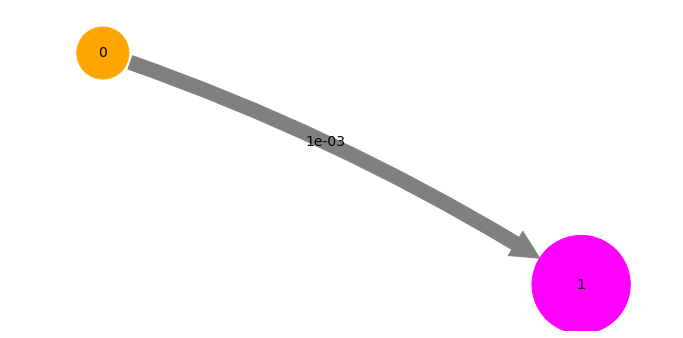

In [7]:
# Let's look at the extremes of the states for TPT
xavg = shortcuts.avg_by_set(cc_x, sets)
A = sets[xavg.argmin()]
B = sets[xavg.argmax()]
# If you know what states you're particularly interested in (e.g., bound and unbound), define A and B accordingly
#A=[0] #starting state(s) -- can be a list
#B=[2] #ending state(s) -- can be a list
fluxAB = pyemma.msm.tpt(M, A, B)
cg, cgflux = fluxAB.coarse_grain(sets)
avgpos = np.zeros((count_slow_processes,2))
avgpos[:,0] = shortcuts.avg_by_set(cc_x, cg)
avgpos[:,1] = shortcuts.avg_by_set(cc_y, cg)
mplt.plot_flux(cgflux, pos=avgpos, state_colors=cols[:count_slow_processes], show_committor=False);
# mean first passage times in MSM lag time
# "If I start a bunch of trajectories in A, how long will I have to wait on average to see a transition to B?"
print(M.mfpt(A, B))
print(M.mfpt(B, A))

References
---------------
1] Prinz, J.-H., H. Wu, M. Sarich, B. G. Keller, M. Senne, M. Held, J. D. Chodera, Ch. Schütte and F. Noé: Markov models of molecular kinetics: Generation and Validation. J. Chem. Phys. 134, 174105 (2011)

[2] Rabiner, L. R.: A tutorial on hidden markov models and selected applications in speech recognition. Proc. IEEE 77, 257--286 (1989)

[3] Noé, F., H. Wu, J.-H. Prinz and N. Plattner, N.: Projected and Hidden Markov Models for calculating kinetics and metastable states of complex molecules. J. Chem. Phys. 139, 184114 (2013)

[4] Djurdjevac, N., Sarich, M. & Schütte, C. Estimating the eigenvalue error of Markov State Models. Multiscale Model. Sim.

[5] P. Metzner, C. Schütte, and E. Vanden-Eijnden: “Transition Path Theory for Markov Jump Processes”. Mult. Mod. Sim. (2007)

[6] F. Noé, C. Schütte, E. Vanden-Eijnden, L. Reich, T. Weikl: “Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations”.